In [14]:
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import LineString, Polygon
from l5kit_conflict.pickle.io import report_AVHV_conflicts, report_HVHV_conflicts
from l5kit_conflict.analysis.post_process import load_l5kit_potential_conflicts_junction1 
from l5kit_conflict.filter.helper import multiline_to_single_line, multi2singleLineString
from l5kit_conflict.analysis.conflict import Conflict, Trajectory
# from l5kit_conflict.analysis.post_process import post_process
from l5kit_conflict.analysis.utils import compute_position_based_velocities

np.set_printoptions(suppress=True)
plt.style.use("ggplot")

In [10]:
def three_sigma_smoothing(signal, window_size=30, threshold=5):
    """
    Apply 3-sigma smoothing to a signal.
    
    Parameters:
        - signal: The input signal to be smoothed.
        - window_size: The size of the smoothing window.
        - threshold: The threshold in terms of standard deviations.
    
    Returns:
        - smoothed_signal: The smoothed signal.
    """
    smoothed_signal = np.zeros_like(signal)
    for i in range(len(signal)):
        start = max(0, i - window_size//2)
        end = min(len(signal), i + window_size//2 + 1)
        window = signal[start:end]
        mean = np.mean(window)
        std = np.std(window)
        if np.abs(signal[i] - mean) > threshold * std:
            smoothed_signal[i] = mean
        else:
            smoothed_signal[i] = signal[i]
    return smoothed_signal

In [11]:
# first junction
import pickle
with open('./lyft_avhv_conflict_j1.pkl', 'rb') as file:
    lyft_avhv_conflict_list1 = pickle.load(file)

with open('./lyft_hvhv_conflict_j1.pkl', 'rb') as file:
    lyft_hvhv_conflict_list1 = pickle.load(file)

lyft_conflict_list1 = lyft_avhv_conflict_list1 + lyft_hvhv_conflict_list1

In [15]:
avhv, hvhv = load_l5kit_potential_conflicts_junction1(delta_time=10)

1> Loading pickle files ...
HVHV dataset #samples: 739
AVHV dataset #samples: 678
2> Removing unnecessary conflicts ...
HVHV dataset #samples: 608
AVHV dataset #samples: 508
3> Removing AVHV conflicts with non-continuous AV trajectories ...
HVHV dataset #samples: 608
AVHV dataset #samples: 479


AxisError: axis 1 is out of bounds for array of dimension 1

In [13]:
# # %% load datasets.
# delta_time = 10  # 10 seconds for now [April 3rd, meeting];
# # AVHV_val_conflict_dataset = load_l5kit_potential_conflicts_junction1(dataset_type="AVHV", dataset_name="validate",
# #                                                            delta_time=delta_time)
# # HVHV_val_conflict_dataset = load_l5kit_potential_conflicts_junction1(dataset_type="HVHV", dataset_name="validate",
# #                                                            delta_time=delta_time)

# # AVHV_train_conflict_dataset = load_l5kit_potential_conflicts_junction1(dataset_type="AVHV", dataset_name="train2",
# #                                                              delta_time=delta_time)
# # HVHV_train_conflict_dataset = load_l5kit_potential_conflicts_junction1(dataset_type="HVHV", dataset_name="train2",
# #                                                              delta_time=delta_time)

# print("Post-processing")
# conflicts = []
# conflicts = conflicts + post_process(AVHV_val_conflict_dataset, "val")
# conflicts = conflicts + post_process(AVHV_train_conflict_dataset, "train")
# # 646 AVHV/HVAV conflicts

Post-processing


NameError: name 'post_process' is not defined

In [5]:
# %% define the collections of TAs.
HVHV_TAs = []
AVHV_TAs = []
HVAV_TAs = []
HVHV_TAs_merge = []
AVHV_TAs_merge = []
HVAV_TAs_merge = []
HVHV_TAs_cross = []
AVHV_TAs_cross = []
HVAV_TAs_cross = []

plt.figure(figsize=(4,3))

print("Calculate the TA distribution")
for index, conflict in enumerate(conflicts):

    first_xyt = np.hstack(
        [conflict.first_trajectory.xy, conflict.first_trajectory.t.reshape((-1,1))])
    second_xyt = np.hstack(
        [conflict.second_trajectory.xy, conflict.second_trajectory.t.reshape((-1,1))])
    
    # extract the trajectory within the study rectangle
    first_xyt = first_xyt[
        (first_xyt[:, 0] <= Trajectory.X_MAX) &
        (first_xyt[:, 0] >= Trajectory.X_MIN) &
        (first_xyt[:, 1] <= Trajectory.Y_MAX) &
        (first_xyt[:, 1] >= Trajectory.Y_MIN)
    ]
    second_xyt = second_xyt[
        (second_xyt[:, 0] <= Trajectory.X_MAX) &
        (second_xyt[:, 0] >= Trajectory.X_MIN) &
        (second_xyt[:, 1] <= Trajectory.Y_MAX) &
        (second_xyt[:, 1] >= Trajectory.Y_MIN)
    ]
    
    # take the first timestamp that two vehicles co-exist
    coexist_start_time = max(first_xyt[0, 2], second_xyt[0, 2])
    first_xyt = first_xyt[
        (conflict.first_time_at_conflict > first_xyt[:, 2]) &
        (first_xyt[:, 2] >= coexist_start_time)
        ]    
    second_xyt = second_xyt[
        (conflict.first_time_at_conflict > second_xyt[:, 2]) &
        (second_xyt[:, 2] >= coexist_start_time)
        ]
    
    # %% discard the samples with short trajectory (unable to calculate position-based speed)
    if first_xyt.shape[0] < 3 or second_xyt.shape[0] < 3:
        continue
    assert first_xyt[0, 2] == second_xyt[0, 2], \
        f"Two vehicles' initial states were not in the same time instant."
    
    
    if first_xyt.shape[0] !=  second_xyt.shape[0]:
        print("Non-equal two trajectories", first_xyt.shape, second_xyt.shape)
        len_traj = min(first_xyt.shape[0], second_xyt.shape[0]) - 2
    else:
        len_traj = first_xyt.shape[0] - 2

    this_traj_TAs = []
    for jdx in range(len_traj-30):
        # %% calculate the length and speed -> to get TA
        len_first_traj = LineString(first_xyt[jdx:, :2]).length 
        first_speed = three_sigma_smoothing(compute_position_based_velocities(first_xyt[jdx+30:jdx+33, :2]))[0]
        len_second_traj = LineString(second_xyt[jdx:, :2]).length
        second_speed = three_sigma_smoothing(compute_position_based_velocities(second_xyt[jdx+30:jdx+33, :2]))[0]
        TA = len_second_traj / second_speed - len_first_traj / first_speed
       
        if conflict.is_first_AV:
            AVHV_TAs.append(TA)
            if conflict.category == "merge":
                AVHV_TAs_merge.append(TA)
            else:
                AVHV_TAs_cross.append(TA)
        else:
            HVAV_TAs.append(TA)
            if conflict.category == "merge":
                HVAV_TAs_merge.append(TA)
            else:
                HVAV_TAs_cross.append(TA)
        this_traj_TAs.append(TA)

Calculate the TA distribution
Non-equal two trajectories (126, 3) (146, 3)


/var/folders/bh/rfgsq1xd0j53cg5bk6h90f4jf31sz6/T/ipykernel_16894/331015951.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  TA = len_second_traj / second_speed - len_first_traj / first_speed
/var/folders/bh/rfgsq1xd0j53cg5bk6h90f4jf31sz6/T/ipykernel_16894/331015951.py:67: RuntimeWarning: invalid value encountered in scalar divide
  TA = len_second_traj / second_speed - len_first_traj / first_speed


Non-equal two trajectories (161, 3) (139, 3)
Non-equal two trajectories (152, 3) (176, 3)


<Figure size 400x300 with 0 Axes>

In [6]:
AVHV_TAs = np.array(AVHV_TAs)
HVAV_TAs = np.array(HVAV_TAs)
AVHV_TAs_merge = np.array(AVHV_TAs_merge)
HVAV_TAs_merge = np.array(HVAV_TAs_merge)
AVHV_TAs_cross = np.array(AVHV_TAs_cross)
HVAV_TAs_cross = np.array(HVAV_TAs_cross)

TA_MIN = -15
TA_MAX = 20

print(AVHV_TAs.shape)

AVHV_TAs = AVHV_TAs[
    (AVHV_TAs >= TA_MIN) &
    (AVHV_TAs <= TA_MAX)
]

print(AVHV_TAs.shape)

HVAV_TAs = HVAV_TAs[
    (HVAV_TAs >= TA_MIN) &
    (HVAV_TAs <= TA_MAX)
]

AVHV_TAs_merge = AVHV_TAs_merge[
    (AVHV_TAs_merge >= TA_MIN) &
    (AVHV_TAs_merge <= TA_MAX)
]
HVAV_TAs_merge = HVAV_TAs_merge[
    (HVAV_TAs_merge >= TA_MIN) &
    (HVAV_TAs_merge <= TA_MAX)
]

AVHV_TAs_cross = AVHV_TAs_cross[
    (AVHV_TAs_cross >= TA_MIN) &
    (AVHV_TAs_cross <= TA_MAX)
]
HVAV_TAs_cross = HVAV_TAs_cross[
    (HVAV_TAs_cross >= TA_MIN) &
    (HVAV_TAs_cross <= TA_MAX)
]

(11345,)
(8551,)


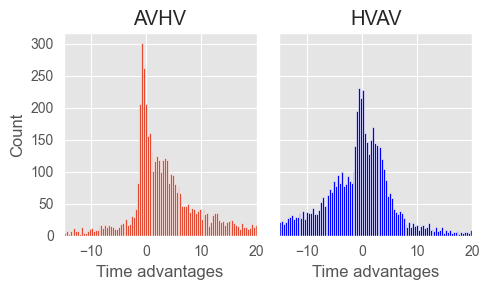

In [7]:
# %% draw distribution
fig, axs = plt.subplots(1, 2, figsize=(5, 3), sharey=True, sharex=True)

sca0 = axs[0].hist(x=AVHV_TAs_merge, bins=100)
sca1 = axs[1].hist(x=HVAV_TAs_merge, bins=100, color='blue')
# sca2 = axs[2].scatter(x=HVAV_PETs_cross, y=HVAV_average_speeds_first_cross, s=20, marker="o", c=HVAV_MRDs_cross, cmap="Reds", vmin=0, vmax=5)

axs[0].set_title(r"AVHV")
axs[0].set_xlabel("Time advantages")
axs[0].set_ylabel("Count")
axs[0].set_xlim([TA_MIN, TA_MAX])

axs[1].set_title(r"HVAV")
axs[1].set_xlabel("Time advantages")
# axs[1].set_ylabel("Average speed")

# axs[2].set_title(r"$\bf{HV}$-AV crossing")
# axs[2].set_xlabel("Post encroachment time")
# axs[2].set_ylabel("Average speed")

plt.tight_layout()
plt.show()

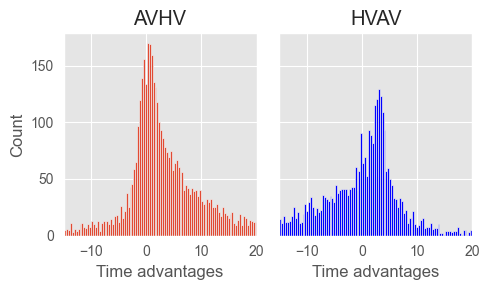

In [8]:
# %% draw distribution
fig, axs = plt.subplots(1, 2, figsize=(5, 3), sharey=True, sharex=True)

sca0 = axs[0].hist(x=AVHV_TAs_cross, bins=100)
sca1 = axs[1].hist(x=HVAV_TAs_cross, bins=100, color='blue')
# sca2 = axs[2].scatter(x=HVAV_PETs_cross, y=HVAV_average_speeds_first_cross, s=20, marker="o", c=HVAV_MRDs_cross, cmap="Reds", vmin=0, vmax=5)

axs[0].set_title(r"AVHV")
axs[0].set_xlabel("Time advantages")
axs[0].set_ylabel("Count")
axs[0].set_xlim([TA_MIN, TA_MAX])

axs[1].set_title(r"HVAV")
axs[1].set_xlabel("Time advantages")
# axs[1].set_ylabel("Average speed")

# axs[2].set_title(r"$\bf{HV}$-AV crossing")
# axs[2].set_xlabel("Post encroachment time")
# axs[2].set_ylabel("Average speed")

plt.tight_layout()
plt.show()

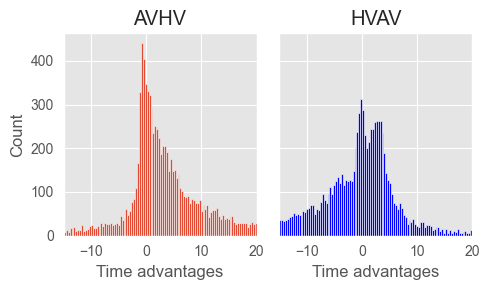

In [9]:
# %% draw distribution
fig, axs = plt.subplots(1, 2, figsize=(5, 3), sharey=True, sharex=True)

sca0 = axs[0].hist(x=AVHV_TAs, bins=100)
sca1 = axs[1].hist(x=HVAV_TAs, bins=100, color='blue')
# sca2 = axs[2].scatter(x=HVAV_PETs_cross, y=HVAV_average_speeds_first_cross, s=20, marker="o", c=HVAV_MRDs_cross, cmap="Reds", vmin=0, vmax=5)

axs[0].set_title(r"AVHV")
axs[0].set_xlabel("Time advantages")
axs[0].set_ylabel("Count")
axs[0].set_xlim([TA_MIN, TA_MAX])

axs[1].set_title(r"HVAV")
axs[1].set_xlabel("Time advantages")
# axs[1].set_ylabel("Average speed")

# axs[2].set_title(r"$\bf{HV}$-AV crossing")
# axs[2].set_xlabel("Post encroachment time")
# axs[2].set_ylabel("Average speed")

plt.tight_layout()
plt.show()

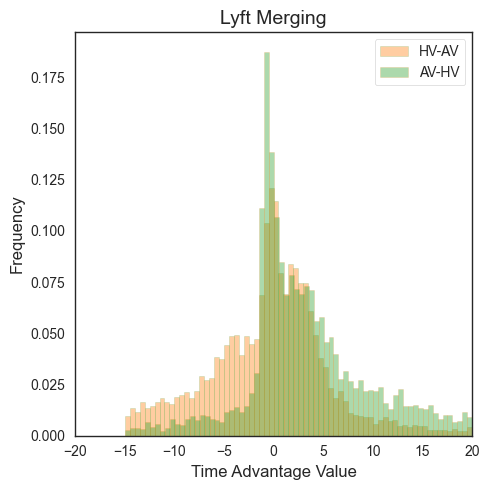

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


TA_MIN = -20
TA_MAX = 20

# Define the custom color palette
palette = {
    "HV-HV": '#257ab6',  # Blue
    "AV-HV": '#31a231',  # Green
    "HV-AV": '#ff8214',  # Orange
}

# Set the Seaborn style without grid
sns.set_style("white")  # Remove grid by using 'white' style

# Create the plot with a square aspect ratio
fig, ax = plt.subplots(figsize=(5, 5))  # Make the figure square

# Use Seaborn to plot the histograms with custom colors
sns.histplot(
    HVAV_TAs_merge,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["HV-AV"],  # Use the custom color from the palette
    alpha=0.4,
    label='HV-AV',
    edgecolor=(49/255, 162/255, 49/255, 0.3)  # Match edge color with the fill color with transparency
)

sns.histplot(
    AVHV_TAs_merge,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["AV-HV"],  # Use another custom color from the palette
    alpha=0.4,
    label='AV-HV',
    edgecolor=(255/255, 130/255, 20/255, 0.3)  # Match edge color with the fill color with transparency
)

# Customize the plot
ax.set_title("Lyft Merging", fontsize=14)
ax.set_xlabel("Time Advantage Value", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_xlim([TA_MIN, TA_MAX])

# Add a legend
ax.legend(loc='upper right', fontsize=10)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


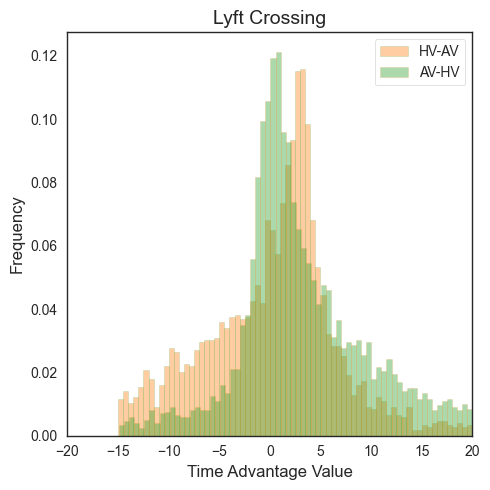

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


TA_MIN = -20
TA_MAX = 20

# Define the custom color palette
palette = {
    "HV-HV": '#257ab6',  # Blue
    "AV-HV": '#31a231',  # Green
    "HV-AV": '#ff8214',  # Orange
}

# Set the Seaborn style without grid
sns.set_style("white")  # Remove grid by using 'white' style

# Create the plot with a square aspect ratio
fig, ax = plt.subplots(figsize=(5, 5))  # Make the figure square

# Use Seaborn to plot the histograms with custom colors
sns.histplot(
    HVAV_TAs_cross,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["HV-AV"],  # Use the custom color from the palette
    alpha=0.4,
    label='HV-AV',
    edgecolor=(49/255, 162/255, 49/255, 0.3)  # Match edge color with the fill color with transparency
)

sns.histplot(
    AVHV_TAs_cross,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["AV-HV"],  # Use another custom color from the palette
    alpha=0.4,
    label='AV-HV',
    edgecolor=(255/255, 130/255, 20/255, 0.3)  # Match edge color with the fill color with transparency
)

# Customize the plot
ax.set_title("Lyft Crossing", fontsize=14)
ax.set_xlabel("Time Advantage Value", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_xlim([TA_MIN, TA_MAX])

# Add a legend
ax.legend(loc='upper right', fontsize=10)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
import pandas as pd
HVAV_merge = pd.DataFrame({'TA':HVAV_TAs_merge})
AVHV_merge = pd.DataFrame({'TA':AVHV_TAs_merge})
HVAV_cross = pd.DataFrame({'TA':HVAV_TAs_cross})
AVHV_cross = pd.DataFrame({'TA':AVHV_TAs_cross})

# HVAV_merge.to_csv("HVAV_merge.csv", index=False)
# AVHV_merge.to_csv("AVHV_merge.csv", index=False)
# HVAV_cross.to_csv("HVAV_cross.csv", index=False)
# AVHV_cross.to_csv("AVHV_cross.csv", index=False)



In [13]:
import pandas as pd
from scipy.stats import ks_2samp, anderson_ksamp

# Extract the column 'TA' from each DataFrame for comparison
hvav_merge_values = HVAV_merge['TA']
avhv_merge_values = AVHV_merge['TA']
hvav_cross_values = HVAV_cross['TA']
avhv_cross_values = AVHV_cross['TA']

# Kolmogorov-Smirnov Test for Merge
ks_statistic_merge, ks_p_value_merge = ks_2samp(hvav_merge_values, avhv_merge_values)
print("Kolmogorov-Smirnov Test for Merge:")
print(f"Statistic: {ks_statistic_merge:.3f}, p-value: {ks_p_value_merge:.3f}")

# Anderson-Darling Test for Merge
ad_result_merge = anderson_ksamp([hvav_merge_values, avhv_merge_values])
print("Anderson-Darling Test for Merge:")
print(f"Statistic: {ad_result_merge.statistic:.3f}, p-value: {ad_result_merge.significance_level:.3f}")

# Kolmogorov-Smirnov Test for Cross
ks_statistic_cross, ks_p_value_cross = ks_2samp(hvav_cross_values, avhv_cross_values)
print("Kolmogorov-Smirnov Test for Cross:")
print(f"Statistic: {ks_statistic_cross:.3f}, p-value: {ks_p_value_cross:.3f}")

# Anderson-Darling Test for Cross
ad_result_cross = anderson_ksamp([hvav_cross_values, avhv_cross_values])
print("Anderson-Darling Test for Cross:")
print(f"Statistic: {ad_result_cross.statistic:.3f}, p-value: {ad_result_cross.significance_level:.3f}")

# Interpret the results
alpha = 0.05  # significance level
print("\nInterpretation:")
if ks_p_value_merge < alpha:
    print("Kolmogorov-Smirnov Test (Merge): Distributions are significantly different.")
else:
    print("Kolmogorov-Smirnov Test (Merge): Distributions are not significantly different.")

if ad_result_merge.significance_level < alpha:
    print("Anderson-Darling Test (Merge): Distributions are significantly different.")
else:
    print("Anderson-Darling Test (Merge): Distributions are not significantly different.")

if ks_p_value_cross < alpha:
    print("Kolmogorov-Smirnov Test (Cross): Distributions are significantly different.")
else:
    print("Kolmogorov-Smirnov Test (Cross): Distributions are not significantly different.")

if ad_result_cross.significance_level < alpha:
    print("Anderson-Darling Test (Cross): Distributions are significantly different.")
else:
    print("Anderson-Darling Test (Cross): Distributions are not significantly different.")


Kolmogorov-Smirnov Test for Merge:
Statistic: 0.250, p-value: 0.000
Anderson-Darling Test for Merge:
Statistic: 500.884, p-value: 0.001
Kolmogorov-Smirnov Test for Cross:
Statistic: 0.184, p-value: 0.000
Anderson-Darling Test for Cross:
Statistic: 173.958, p-value: 0.001

Interpretation:
Kolmogorov-Smirnov Test (Merge): Distributions are significantly different.
Anderson-Darling Test (Merge): Distributions are significantly different.
Kolmogorov-Smirnov Test (Cross): Distributions are significantly different.
Anderson-Darling Test (Cross): Distributions are significantly different.


/var/folders/bh/rfgsq1xd0j53cg5bk6h90f4jf31sz6/T/ipykernel_16894/2611891134.py:16: UserWarning: p-value floored: true value smaller than 0.001
  ad_result_merge = anderson_ksamp([hvav_merge_values, avhv_merge_values])
/var/folders/bh/rfgsq1xd0j53cg5bk6h90f4jf31sz6/T/ipykernel_16894/2611891134.py:26: UserWarning: p-value floored: true value smaller than 0.001
  ad_result_cross = anderson_ksamp([hvav_cross_values, avhv_cross_values])
